In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader

import argparse
import sys
sys.argv = ['run.py']

import h5py
import copy
import matplotlib.pyplot as plt

In [2]:
from Gan_convolutional_new20size import Discriminator, Generator, generate_random_image, generate_random_one_hot, generate_random_seed, Train_D, evaluate_D , Train_G

In [3]:
parser = argparse.ArgumentParser()

parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=100, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')

parser.add_argument('--imgage-size', type=int, default=20,help='input image size')

parser.add_argument('--imgage-patch', type=int, default=4,help='segmentation image patch')

parser.add_argument('--channels', type=int, default=2, help='_')

parser.add_argument('--mlp-dim', type=int, default=500, help='_')


parser.add_argument('--dropout-rate', type=int, default=0.2, help='_')

parser.add_argument('--learning-rate', type=int, default=1e-4, help='_')


args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if args.cuda else "cpu")

## Data preperation

In [4]:
data = []


M_raw = []

#load monte carlo simulation generated raw data
with h5py.File('124_MT_20size_1T_jiangede.hdf5', 'r') as f:

    for i in np.arange(1,51):   
    
        dataset=f[str(i)+'.0K']

        data.append(dataset[:])

        M_raw.append(dataset[:].mean(axis=(0,2,3)).sum())


M_raw=np.array(M_raw)

data=np.array(data)
print(data.shape)

data_T_num, sample_num,_,_,_ = data.shape


data=data.reshape(-1, args.channels, args.imgage_size, args.imgage_size)

print('Train data shape {}'.format(data.shape))
# print('Test data shape {}'.format(data_test.shape))


T = np.linspace(1,50,data_T_num)

#One hot encoding
One_hot_code=np.zeros((data_T_num*sample_num, data_T_num))

for i in range(data_T_num*sample_num):

    One_hot_code[i,i//sample_num]=1
    


#Transform the train data into [0,1],turn into tensor
data_set=(data+1)/2
data_set=torch.tensor(data_set).to(torch.float32)


#Transform the one hot coding to tensor
One_hot_code=torch.tensor(One_hot_code).to(torch.long)

print(data_set.shape)

print(One_hot_code.shape)

# Consolidate data and One hot coding
data_all=[[data_set[i], One_hot_code[i]] for i in range(sample_num*data_T_num)]


print(len(data_all))

(50, 500, 2, 20, 20)
Train data shape (25000, 2, 20, 20)
torch.Size([25000, 2, 20, 20])
torch.Size([25000, 50])
25000


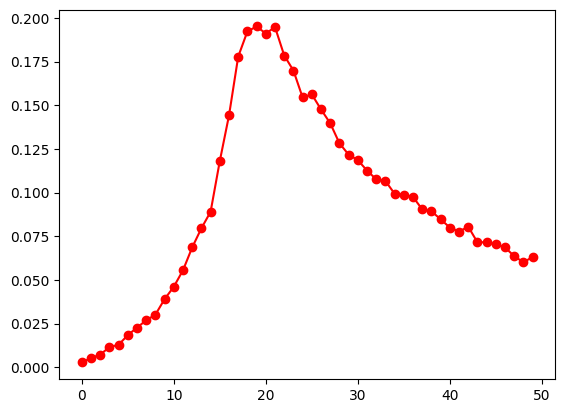

In [5]:
plt.plot(M_raw,'ro-')
plt.show()

In [6]:
batchsize=200

shuffled_indices = np.random.permutation(len(data_all))

train_idx = shuffled_indices[:int(0.8*len(data_all))]
val_idx = shuffled_indices[int(0.8*len(data_all)):]

data_train=[data_all[i] for i in train_idx]
data_test=[data_all[i] for i in val_idx]

train_loader = DataLoader(data_train, batch_size = batchsize, shuffle=True)
test_loader = DataLoader(data_test, batch_size = batchsize, shuffle=True )

# train_loader = DataLoader(data_all, batch_size = batchsize, drop_last=False, sampler=SubsetRandomSampler(train_idx))
# test_loader = DataLoader(data_all, batch_size = batchsize, drop_last=False, sampler=SubsetRandomSampler(val_idx) )

## Train Discriminator

In [7]:
%%time
epochs=100
# v_dim = 2*20*20
# z_dim = 100
# h_dim=500
learning_rate=8e-5
class_num=len(T)
in_channels=2
h_channels=64

model_D = Discriminator(h_dim=args.mlp_dim, in_channels=args.channels, h_channels=h_channels,learning_rate=learning_rate, class_num=class_num, dropout_rate=0.3)
# move model to cuda device
model_D.to(device)

optimizer = torch.optim.Adam(model_D.parameters(), lr=learning_rate)

train_loss_history, test_loss_history, Accuracy_rate = [], [], []
for epoch in range( epochs ):
    # print('Epoch:', epoch)
    Train_D(model_D, optimizer, train_loader, train_loss_history, epoch, class_num)
    evaluate_D(model_D, test_loader, test_loss_history,Accuracy_rate, epoch, class_num)

Epoch 1:, Average train loss: 0.53686
Epoch 1: Average test loss: 0.60200  Accuracy: 8747/10000 (87.47%)

Epoch 2:, Average train loss: 0.26038
Epoch 2: Average test loss: 0.33840  Accuracy: 9304/10000 (93.04%)

Epoch 3:, Average train loss: 0.17267
Epoch 3: Average test loss: 0.25315  Accuracy: 9490/10000 (94.90%)

Epoch 4:, Average train loss: 0.13824
Epoch 4: Average test loss: 0.23224  Accuracy: 9518/10000 (95.18%)

Epoch 5:, Average train loss: 0.11753
Epoch 5: Average test loss: 0.23403  Accuracy: 9513/10000 (95.13%)

Epoch 6:, Average train loss: 0.09967
Epoch 6: Average test loss: 0.18139  Accuracy: 9634/10000 (96.34%)

Epoch 20:, Average train loss: 0.02668
Epoch 20: Average test loss: 0.17063  Accuracy: 9683/10000 (96.83%)

Epoch 40:, Average train loss: 0.08310
Epoch 40: Average test loss: 0.12241  Accuracy: 9746/10000 (97.46%)



KeyboardInterrupt: 

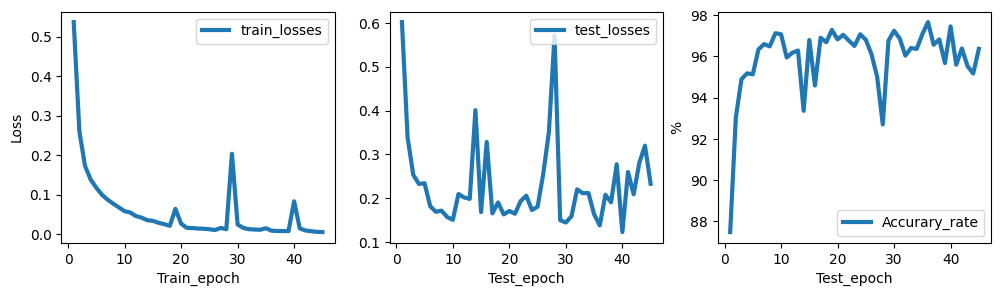

In [8]:
fig=plt.figure(figsize=(12,3))

ax1=plt.subplot(131)
ax1.plot(np.arange(1,len(train_loss_history)+1),train_loss_history, linewidth=3, linestyle='-', label='train_losses')
ax1.set_xlabel('Train_epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2=plt.subplot(132)
ax2.plot(np.arange(1,len(test_loss_history)+1),test_loss_history, linewidth=3, linestyle='-', label='test_losses')
ax2.set_xlabel('Test_epoch')
ax2.legend()

ax3=plt.subplot(133)
ax3.plot(np.arange(1,len(Accuracy_rate)+1),Accuracy_rate, linewidth=3, linestyle='-', label='Accurary_rate')
ax3.set_xlabel('Test_epoch')
ax3.set_ylabel('%')
ax3.legend()

plt.show()

## Train GAN

In [10]:
%%time

epochs=80
# v_dim = 2*20*20
z_dim = 100
h_dim=500
learning_rate=5e-5
class_num=len(T)
in_channels=2
h_channels=64*2

D_model = Discriminator(h_dim=h_dim, in_channels=in_channels, h_channels=h_channels,learning_rate=learning_rate, class_num=class_num, dropout_rate=0.1)
D_model.to(device)
G_model = Generator(h_dim=h_dim+500, z_dim=z_dim, out_channels=in_channels, h_channels=h_channels,learning_rate=learning_rate, class_num=class_num, dropout_rate=0.1)
G_model.to(device)#+200

optimizer_d = torch.optim.Adam(D_model.parameters(), lr=learning_rate)
optimizer_g = torch.optim.Adam(G_model.parameters(), lr=learning_rate)


G_loss_history, D_loss_history = [], []
for epoch in range( epochs ):
    # print('Epoch:', epoch)
    Train_G(z_dim, G_model, D_model, optimizer_d, optimizer_g,  train_loader, D_loss_history, G_loss_history, epoch, class_num)

Epoch: 1, D_loss: 0.14023650090181036, G_loss: 5.114721743427217
Epoch: 2, D_loss: 0.010334162537765224, G_loss: 6.573021836280823
Epoch: 3, D_loss: 0.008859512833878399, G_loss: 6.493687705993652
Epoch: 4, D_loss: 0.0931682271475438, G_loss: 4.348358993530273
Epoch: 5, D_loss: 0.08011399384588003, G_loss: 3.7872396302223206
Epoch: 6, D_loss: 0.08738768149167299, G_loss: 3.6033518218994143
Epoch: 20, D_loss: 0.26141355849802494, G_loss: 2.3602586603164672
Epoch: 40, D_loss: 0.1750205135717988, G_loss: 4.314959621429443
Epoch: 60, D_loss: 0.10337016236037017, G_loss: 5.027306699752808
Epoch: 80, D_loss: 0.2207283002138138, G_loss: 3.637196891307831
Wall time: 11min 12s


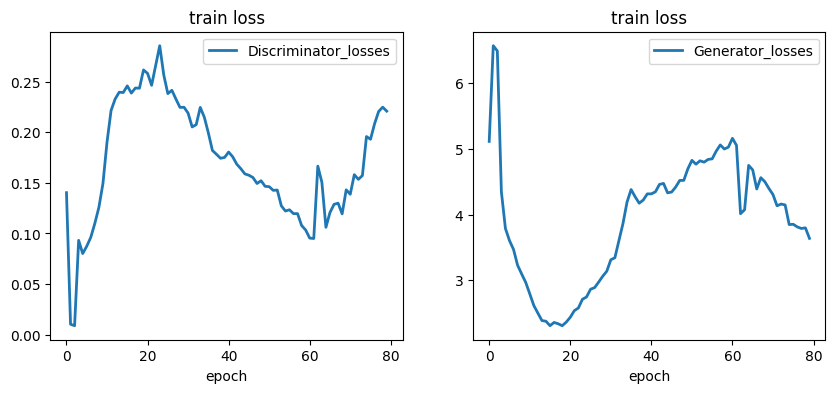

In [16]:
# plot discriminator error

fig = plt.figure(figsize=(10,4))
ax1=plt.subplot(121)
ax1.set_title('train loss')
ax1.plot(np.arange(len(D_loss_history)), D_loss_history, linewidth=2, linestyle='-', label='Discriminator_losses')
ax1.set_xlabel('epoch')
ax1.legend()

ax2=plt.subplot(122)
ax2.set_title('train loss')
ax2.plot(np.arange(len(G_loss_history)), G_loss_history, linewidth=2, linestyle='-', label='Generator_losses')
ax2.set_xlabel('epoch')
ax2.legend()

plt.show()

In [17]:
M_generated=[]
Susceptibility = []

sample_num=500
for ii in range(0,len(T)):
    Code=torch.zeros(50)
    Code[ii]=1.0

    cal_M = 0
    cal_M_2=0
    # cal_E = 0
    # cal_E_2 = 0
    for jj in range(sample_num):
        output=G_model.forward(generate_random_seed(1,z_dim).cuda(), Code.reshape(1,50).cuda())
        img = output.detach().cpu().numpy().reshape(2,20,20)
        generated_img=img*2-1

        cal_M += generated_img.mean(axis=(1,2)).sum()
        cal_M_2 += (generated_img.mean(axis=(1,2)).sum())**2


    cal_M = cal_M/sample_num
    cal_M_2 = cal_M_2/sample_num

    # E.append(copy.deepcopy(cal_M))
    # Cv.append(copy.deepcopy((1/(ii+1)**2)*(cal_E_2 - cal_E**2)))

    M_generated.append(cal_M.copy())
    Susceptibility.append(((1/(ii+1))*(cal_M_2-cal_M**2)))


M_generated=np.array(M_generated)
Susceptibility=np.array(Susceptibility)

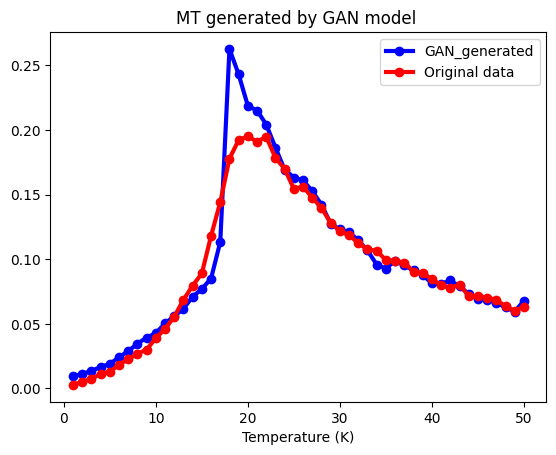

In [19]:
plt.plot(T, M_generated,'bo-',markersize=6,lw=3,label='GAN_generated')
plt.plot(T, M_raw,'ro-',markersize=6,lw=3,label='Original data')
# plt.plot(T, M_raw_test,'yo-',markersize=6,lw=3,label='testl data')

plt.title('MT generated by GAN model ')
plt.xlabel('Temperature (K)')
plt.legend()
plt.show()

Text(0.5, 0, 'Temperature (K)')

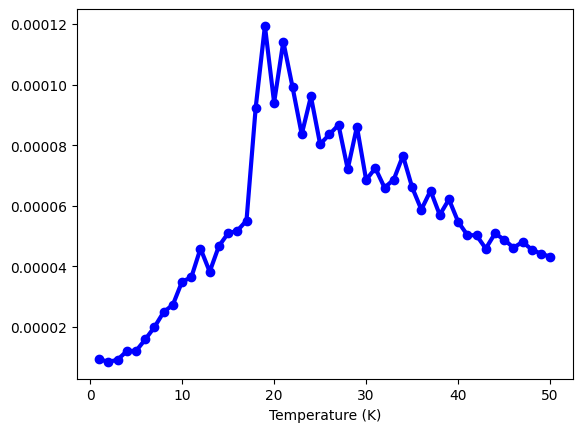

In [20]:
plt.plot(T, Susceptibility,'bo-',markersize=6,lw=3)
plt.xlabel('Temperature (K)')

In [ ]:
# torch.save(G_model,"Trained_model_saving/G_0424_20size.pth")
# torch.save(D_model,"Trained_model_saving/D_0424_20size.pth")# saving the whole model

In [ ]:
# reloaded_G=torch.load("Trained_model_saving/G_0418.pth")
# reloaded_D=torch.load("Trained_model_saving/G_0418.pth")